# Based off Spatial Data lab

In [1]:
# basic
import os
import pandas as pd
import numpy as np
from datetime import datetime
from urllib.request import urlretrieve
from zipfile import ZipFile
import pysal
from sklearn import metrics

# geo
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
def get_data(filename):
    #print(type(filename), filename)
    
    #1. read in data
    data = pd.read_csv(filename)
    #print(data.shape)
    
    #2. drop null index col, null rows where date does not exist in month
    data.drop(['Unnamed: 0'], axis=1, inplace = True)
    data = data[data['state code'].isnull() == False]
    #print(data.shape)
    
    #3. convert data columns to desired type
    data['issue date'] = pd.to_datetime(data['issue date'])
    data['valid date'] = pd.to_datetime(data['valid date'])
    
    data['record sequence'] = data['record sequence'].astype('int64')
    data['action day']=[True if day == 'Yes' else False for day in data['action day']]    #no missing values
    
    data['urldate'] = pd.to_datetime(data['urldate'])
    #print(data.dtypes)
    
    #4. create calculated data column: feature
    data['categorical'] = [1 if (cat == 'Good' or cat == 'Moderate') else 0 for cat in data['AQI category']]
    #print(data.shape)
    
    return(data)

In [3]:
data = get_data('../Data/data.csv')

In [4]:
def relevant_data(datadf, reparea):
    datadf = datadf[datadf['data type'] == 'O']
    datadf = datadf[datadf['reporting area'] == reparea]
    datadf.drop_duplicates(['valid date'], keep = 'first', inplace = True)
    return (datadf)

In [5]:
sfdata = relevant_data(data, 'San Francisco')
sfdata.shape

(367, 19)

In [6]:
#1. Identify Reporting areas around San Francisco
print(len(list(data[data['state code'] == 'CA']['reporting area'].unique())))
list(data[data['state code'] == 'CA']['reporting area'].unique())[0:10]

165


['Antelope Vly',
 'Anza Vly',
 'Arden Arcade-Del Paso Manor',
 'Atascadero',
 'Auburn',
 'Bakersfield',
 'Banning',
 'Barstow',
 'Big Bear Lake',
 'Bishop']

In [7]:
#look at locations of unique reporting areas
ca_repareas = data[data['state code'] == 'CA'][['reporting area', 'forecast source', 'latitude', 'longitude']].drop_duplicates(['reporting area'], keep = 'first')
print(len(ca_repareas))
display(ca_repareas[0:10])

165


,reporting area,forecast source,latitude,longitude
72,Antelope Vly,Antelope Valley AQMD,34.6694,-118.1305
87,Anza Vly,South Coast AQMD,33.5603,-116.7659
124,Arden Arcade-Del Paso Manor,Sacramento Metro. AQMD,38.6138,-121.3680
160,Atascadero,San Luis Obispo County APCD,35.4900,-120.6900
193,Auburn,Sacramento Metro. AQMD,38.8963,-121.0784
238,Bakersfield,San Joaquin Valley Unified APCD,35.3577,-119.0046
248,Banning,South Coast AQMD,33.9208,-116.8583
262,Barstow,Mojave Desert AQMD,34.8938,-117.0244
343,Big Bear Lake,South Coast AQMD,34.1734,-116.8851
369,Bishop,Great Basin Unified Air Pollution Control Dist...,37.3615,-118.3952


In [8]:
#Reporting areas 'TestA' and 'TestC' have zero lat / long values
    #dropping from ca_repareas
ca_repareas = ca_repareas[ca_repareas['reporting area'] != 'TestA']
ca_repareas = ca_repareas[ca_repareas['reporting area'] != 'TestC']
print(ca_repareas.shape)

(163, 4)


In [9]:
#convert to geodataframe
geometry = [Point(xy) for xy in zip(ca_repareas['longitude'], ca_repareas['latitude'])]
print(len(geometry))

crs = {'init' :'epsg:4326'}
ca_gdf = gpd.GeoDataFrame(ca_repareas, crs = crs, geometry = geometry)
print(ca_gdf.shape)
ca_gdf.head(5)

163
(163, 5)


,reporting area,forecast source,latitude,longitude,geometry
72,Antelope Vly,Antelope Valley AQMD,34.6694,-118.1305,POINT (-118.1305 34.6694)
87,Anza Vly,South Coast AQMD,33.5603,-116.7659,POINT (-116.7659 33.5603)
124,Arden Arcade-Del Paso Manor,Sacramento Metro. AQMD,38.6138,-121.3680,POINT (-121.368 38.6138)
160,Atascadero,San Luis Obispo County APCD,35.4900,-120.6900,POINT (-120.69 35.49)
193,Auburn,Sacramento Metro. AQMD,38.8963,-121.0784,POINT (-121.0784 38.8963)


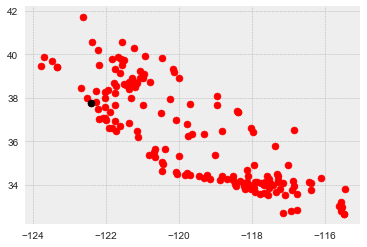

In [10]:
#2. Locate Reporting areas by geometries (lat/long) and plot
    #plt.scatter(ca_gdf['longitude'], ca_gdf['latitude']);

fig, ax = plt.subplots()
ca_gdf.plot(ax = ax, color = 'r');
ca_gdf[ca_gdf['reporting area'] == 'San Francisco'].plot(ax = ax, color = 'k');

In [11]:
#3. Create Reporting area centroids
#if area was readily available for each Reporting area, could map Polygons find centroid and determine distance from centroids
    #below using Points since lat/long available

In [20]:
#4. Calculate distances between Rep area centroids to SF centroid
ca_gdf['sf_geometry'] = ca_gdf[ca_gdf['reporting area'] == 'San Francisco']['geometry'].values[0]
sf_geometry = ca_gdf[ca_gdf['reporting area'] == 'San Francisco']['geometry'].values[0]

distance = ca_gdf['geometry'].distance(sf_geometry)
ca_gdf['distance'] = distance
data['distance'] = distance    #set in both geopandas and pandas dfs
display(ca_gdf.sort_values(['distance']).iloc[1:6, :])
display(ca_gdf.sort_values(['distance']).tail())


,reporting area,forecast source,latitude,longitude,geometry,sf_geometry,distance
3140,Oakland,San Francisco Bay Area AQMD,37.80,-122.27,POINT (-122.27 37.8),POINT (-122.43 37.75),0.167631
3952,San Rafael,San Francisco Bay Area AQMD,37.97,-122.52,POINT (-122.52 37.97),POINT (-122.43 37.75),0.237697
3617,Redwood City,San Francisco Bay Area AQMD,37.48,-122.22,POINT (-122.22 37.48),POINT (-122.43 37.75),0.342053
1581,Fremont,San Francisco Bay Area AQMD,37.55,-122.03,POINT (-122.03 37.55),POINT (-122.43 37.75),0.447214
961,Concord,San Francisco Bay Area AQMD,37.97,-122.03,POINT (-122.03 37.97),POINT (-122.43 37.75),0.456508


,reporting area,forecast source,latitude,longitude,geometry,sf_geometry,distance
4880,Westmorland,Imperial County Air Pollution Control District,33.0325,-115.6225,POINT (-115.6225 33.0325),POINT (-122.43 37.75),8.282322
422,Brawley,Imperial County Air Pollution Control District,32.9783,-115.5383,POINT (-115.5383 32.9783),POINT (-122.43 37.75),8.382401
1945,Imperial Valley,Imperial County Air Pollution Control District,32.7919,-115.5637,POINT (-115.5637 32.7919),POINT (-122.43 37.75),8.469288
559,Calexico,Imperial County Air Pollution Control District,32.6761,-115.4833,POINT (-115.4833 32.6761),POINT (-122.43 37.75),8.602389
1326,El Centro,Imperial County Air Pollution Control District,32.6761,-115.4833,POINT (-115.4833 32.6761),POINT (-122.43 37.75),8.602389


In [96]:
#5. Use distance as weight for prediction of SF AQI value
    #closest distance --> greatest weight

neighbors = {}

for area in ca_gdf['reporting area']:
    #print(area)
    
    areas = list(ca_gdf['reporting area'].unique())
    areas.remove(area)
    #print(areas)
    
    neighbors[area] = areas

#Attempting to create weight matrix here
    ## Talked to Matt Brems: could pass in a shape file if areal data; right now lat/long data
weights = pysal.weights.weights.W(neighbors = neighbors)
weights

In [97]:
#Using distance as weight
def predictors(n, datadf):
    predictor_areas = datadf.sort_values(['distance']).head(n+1)
    predictor_areas = predictor_areas[predictor_areas['reporting area'] != 'San Francisco']
    
    #assign inverse weight based on distance in predictor df
    weight = [i/sum(predictor_areas['distance']) for i in predictor_areas['distance']]
    predictor_areas['weight'] = weight[::-1]
    
    return (predictor_areas)


In [98]:
#6. Predict SF AQI value on same Valid date from Rep Area AQI values by distance
    #modelling with 3 reporting area predictors (by closest distance)

#determining predictor area AQI values
pred = predictors(3, data)
pred

,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,...,pollutant,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical,distance,weight
3140,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Oakland,CA,37.80,...,PM2.5,33.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.167631,0.457669
3952,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,San Rafael,CA,37.97,...,OZONE,23.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.237697,0.318041
3617,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Redwood City,CA,37.48,...,OZONE,23.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.342053,0.224291


In [99]:
#relevant data for reporting areas in pred
def predictor_data(datadf, preddf):
    sfdata = relevant_data(datadf = datadf, reparea = 'San Francisco')
    for i, area in enumerate(preddf['reporting area']):
        areadata = relevant_data(datadf = datadf, reparea = area)
        #print(i, area, areadata.shape)
        if i == 0:
            preddata = pd.concat([areadata, sfdata], axis=0, ignore_index=True)
        else:
            preddata = pd.concat([areadata, preddata], axis=0, ignore_index=True)
    #print(preddata.shape)
    return(preddata)

In [100]:
preddata = predictor_data(data, pred)
preddata.head(5)

,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,longitude,pollutant,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical,distance
0,2017-06-05,2017-06-05,21:00,PDT,0,O,Y,Redwood City,CA,37.48,-122.22,PM2.5,42.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170605,1,NaN
1,2017-06-06,2017-06-06,21:00,PDT,0,O,Y,Redwood City,CA,37.48,-122.22,OZONE,28.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170606,1,NaN
2,2017-06-07,2017-06-07,21:00,PDT,0,O,Y,Redwood City,CA,37.48,-122.22,OZONE,22.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170607,1,NaN
3,2017-06-08,2017-06-08,21:00,PDT,0,O,Y,Redwood City,CA,37.48,-122.22,OZONE,18.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170608,1,NaN
4,2017-06-09,2017-06-09,21:00,PDT,0,O,Y,Redwood City,CA,37.48,-122.22,OZONE,28.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170609,1,NaN


In [101]:
#set up model to predict SF AQI value on Valid date

def predictor_model(preddatadf, preddf):
    aqi_predictions = {}
    missing_preds = 0
    
    #clean up date formatting
    dates = [datetime.date(date.to_datetime()).isoformat() for date in preddatadf['valid date']]
    #return unique dates sorted
    dates = sorted(list(set(dates)))
    
    for date in dates:
        #print(date)
        
        #filter df for date-specific values
        datefilter = preddatadf[preddatadf['valid date'] == date]

        area_aqis = {}
        missing_areas = 0
        
        for area in preddf['reporting area'].unique():
            #if area has reported an AQI value on given date
            
            if datefilter[datefilter['reporting area'] == area]['AQI value'].any() == True:
                area_aqi = datefilter[datefilter['reporting area'] == area]['AQI value'].values[0]
                area_aqis[area] = area_aqi
                #print(area_aqi)
                
            #if area AQI value is unavailalable from dataset on given date
                #option 1: take most recently available AQI value
                #option 2: disregard and redistribute weight among available AQI values --> using this approach below
                
            else:
                area_aqi = 0
                area_aqis[area] = area_aqi
                missing_areas+=1
            
        #number of total predictive areas
        t = len(preddf)
        
        #number of predictive areas with AQI value on given date
        area_aqis_list = list(area_aqis.values())
        
        p = t - missing_areas
        #print('Available predictor areas on given date:', p, '\n','Predictor AQI values:', area_aqis_list)    #IMPT PRINT STATEMENT
        
        #case 1: all predictor areas show AQI value
        if p == t:
            aqi_prediction = np.dot(area_aqis_list, preddf['weight'].values)
            #print('Total '+str(t)+' predictor values:', aqi_prediction)
        
        #case 2: partial predictor areas show AQI value
        elif (p > 0) & (p < t):
            aqi_prediction = np.dot(area_aqis_list, preddf['weight'].values) * (t/p)    #redistributes weight across areas with AQI values
            #print('Partial '+str(p)+' predictor values:', aqi_prediction)
        
        #case 3: no predictor areas show AQI value
        else:
            aqi_prediction = 0
            missing_preds += 1
            #print('No predictor values:', aqi_prediction)
        
        #update AQI prediction for given date in dict, reformat date from datetime
        aqi_predictions[date] = np.round(aqi_prediction, 0)
        #print('\n')
    
    #print(missing_preds)
    return(aqi_predictions)

In [102]:
def actual_aqis(predictions, preddatadf):
    #filter to desired location
    areafilter = preddatadf[preddatadf['reporting area'] == 'San Francisco']
    
    actual_aqis = []
    missing_actuals = 0
    
    for date in list(predictions.keys()):
        #print(date)
        if areafilter[areafilter['valid date'] == date]['AQI value'].any() == True:
            actual_aqi = areafilter[areafilter['valid date'] == date]['AQI value'].values[0]
            actual_aqis.append(actual_aqi)
        else:
            actual_aqi = 0.0
            actual_aqis.append(actual_aqi)
            missing_actuals += 1
            #print(date, 'Missing actual AQI value')
    
    #print(missing_actuals)
    return(actual_aqis)
        

In [104]:
predictions3 = predictor_model(preddata, pred)
pred_dates3 = list(predictions3.keys())
pred_aqis3 = list(predictions3.values())
print(len(pred_dates3), len(pred_aqis3))

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


371 371


In [106]:
actuals3 = actual_aqis(predictions3, preddata)
len(actuals3)

371

In [107]:
#7. Evaluate prediction against actual for each Valid date in relevant dataset
    #Mean absolute error

actuals3 = np.array(actuals3)
preds3 = np.array(pred_aqis3)
metrics.mean_absolute_error(actuals3, preds3)

10.501347708894878

In [108]:
#8. Calculate and plot residuals
residuals3 = actuals3 - preds3

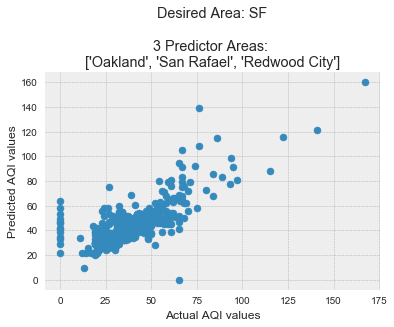

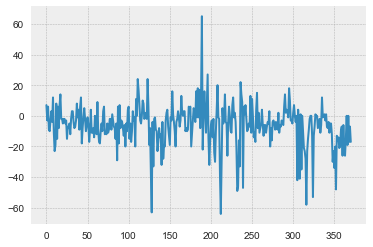

In [109]:
title = list(pred['reporting area'])

plt.title('Desired Area: SF'+'\n\n'+str(len(title))+' Predictor Areas: \n'+str(title))
plt.xlabel('Actual AQI values')
plt.ylabel('Predicted AQI values')
plt.scatter(actuals3, pred_aqis3)
plt.show()

plt.plot(residuals3)
plt.show()


# Manual iteration: 15 closes reporting areas as predictors

In [111]:
pred = predictors(15, data)
pred

,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,...,pollutant,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical,distance,weight
3140,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Oakland,CA,37.8000,...,PM2.5,33.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.167631,0.091490
3952,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,San Rafael,CA,37.9700,...,OZONE,23.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.237697,0.091121
3617,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Redwood City,CA,37.4800,...,OZONE,23.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.342053,0.087277
1581,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Fremont,CA,37.5500,...,OZONE,28.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.447214,0.085922
961,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Concord,CA,37.9700,...,PM2.5,35.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.456508,0.084478
2830,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Napa,CA,38.3300,...,OZONE,31.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.599083,0.084076
1407,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Fairfield,CA,38.2500,...,OZONE,34.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.634114,0.076143
2336,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,Livermore,CA,37.6800,...,OZONE,29.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.663702,0.074731
3906,2017-06-01,2017-05-31,NaN,PDT,-1,Y,Y,San Jose,CA,37.3300,...,OZONE,34.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,0.676240,0.071399
3918,2017-05-31,2017-06-01,NaN,PDT,1,F,Y,San Lorenzo Valley,CA,37.0881,...,OZONE,NaN,Good,False,"May 31 to June 4, 2017 ?The weak low pressure ...",Monterey Bay Unified APCD,1970-01-01 00:00:00.020170601,1,0.746693,0.067455


In [112]:
preddata = predictor_data(data, pred)
preddata.shape

(4690, 20)

In [113]:
list(preddata['reporting area'].unique())

['Rio Vista',
 'Vacaville',
 'Santa Rosa',
 'San Jose',
 'Livermore',
 'Fairfield',
 'Napa',
 'Concord',
 'Fremont',
 'Redwood City',
 'San Rafael',
 'Oakland',
 'San Francisco']

In [115]:
predictions15 = predictor_model(preddata, pred)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


383
MAE: 11.53


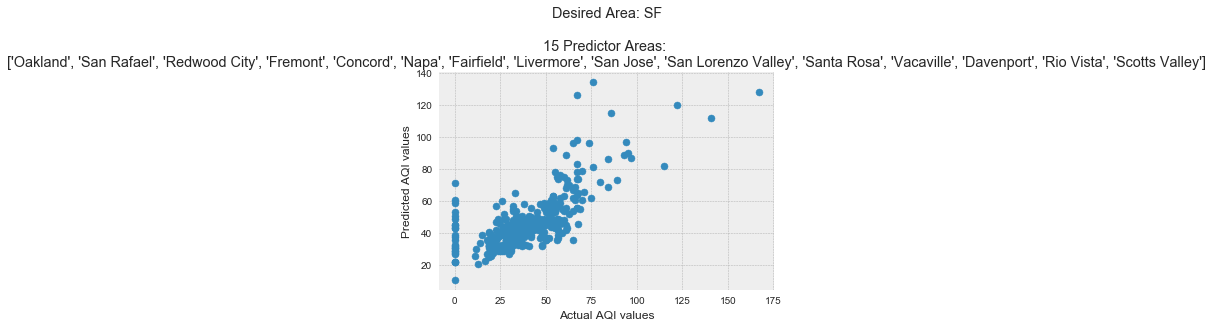

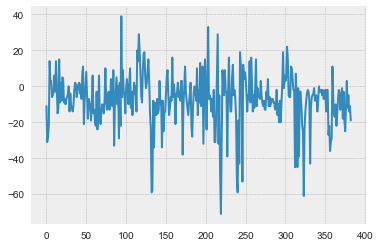

In [152]:
pred_dates15 = list(predictions15.keys())
pred_aqis15 = list(predictions15.values())
#print(len(pred_dates15), len(pred_aqis15))
    
#return and save actual results
actuals15 = actual_aqis(predictions15, preddata)
print(len(actuals15))
    
#evalute model results
actuals15 = np.array(actuals15)
preds15 = np.array(pred_aqis15)
residuals15 = actuals15 - preds15
mae = np.round(metrics.mean_absolute_error(actuals15, preds15), 2)
print('MAE:', mae)

#plot model results
#scatterplot
title = list(pred['reporting area'])
plt.title('Desired Area: SF'+'\n\n'+str(len(title))+' Predictor Areas: \n'+str(title))
plt.xlabel('Actual AQI values')
plt.ylabel('Predicted AQI values')
plt.scatter(actuals15, pred_aqis15)
plt.show()
    
#residplot
plt.plot(residuals15)
plt.show()

# Function for various predictor areas

In [147]:
#n = number of predictor areas

def run_model(n, datadf):
    #return relevant data
    pred = predictors(n, datadf)
    #print(pred)
    
    preddata = predictor_data(datadf, pred)
    #print(preddata.shape)
    
    #return and save model results
    predictions = predictor_model(preddata, pred)
    #print(predictions.values())
    
    pred_dates = list(predictions.keys())
    pred_aqis = list(predictions.values())
    #print(len(pred_dates), len(pred_aqis))
    
    #return and save actual results
    actuals = actual_aqis(predictions, preddata)
    #print(len(actuals))
    
    #evalute model results
    actuals = np.array(actuals)
    preds = np.array(pred_aqis)
    residuals = actuals - preds
    mae = np.round(metrics.mean_absolute_error(actuals, preds), 2)
    print('MAE:', mae)

    #plot model results
    #scatterplot
    title = list(pred['reporting area'])

    plt.title('Desired Area: SF'+'\n\n'+str(len(title))+' Predictor Areas: \n'+str(title))
    plt.xlabel('Actual AQI values')
    plt.ylabel('Predicted AQI values')
    plt.scatter(actuals, pred_aqis)
    plt.show()
    
    #residplot
    plt.plot(residuals)
    plt.show()
    
    return (mae, list(preds))

In [167]:
#9. Further model evaluation
    #comparing models with different numbers of predictor areas: "Gridsearch"
    #snapshot shows fairly varied predictions numerically but would still fall into same AQI category

def gridsearch_n(n_list, datadf):    
    results = {}
    for n in n_list:
        pred_aqis = run_model(n, datadf)
        mae = pred_aqis[0]
        vals = pred_aqis[1]
        results[n] = [mae, vals[0:15]]
    return (results)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


MAE: 12.62


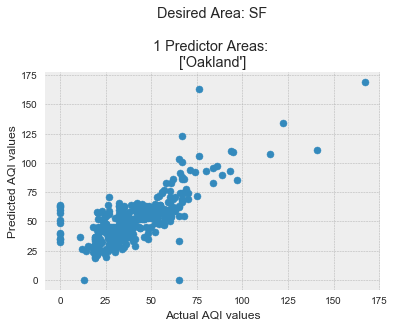

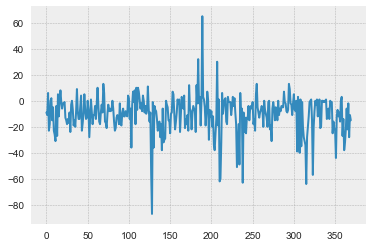

MAE: 11.04


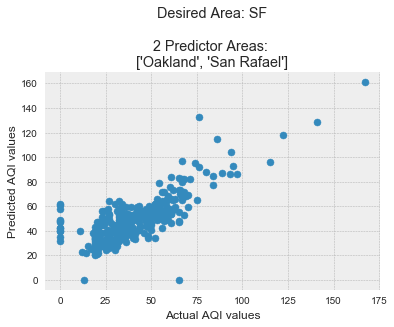

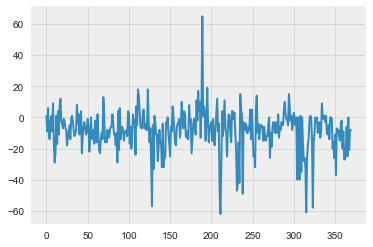

MAE: 10.5


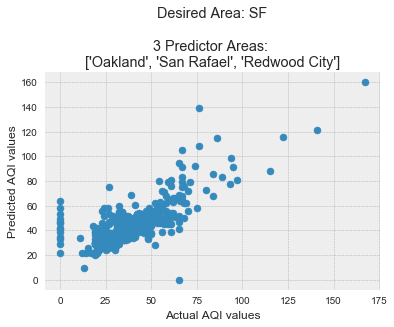

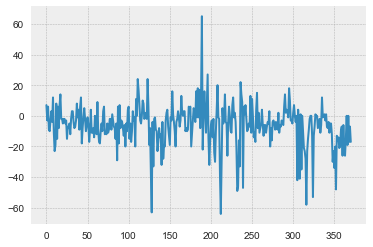

MAE: 9.81


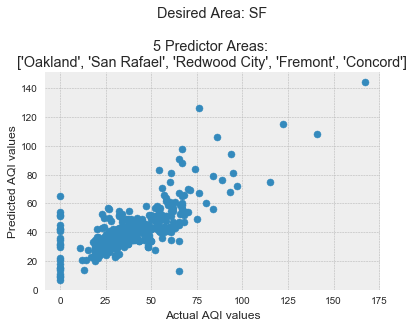

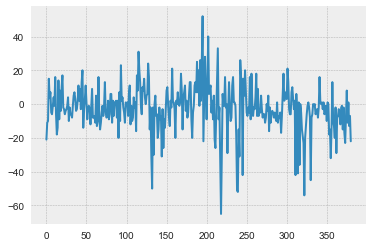

MAE: 10.3


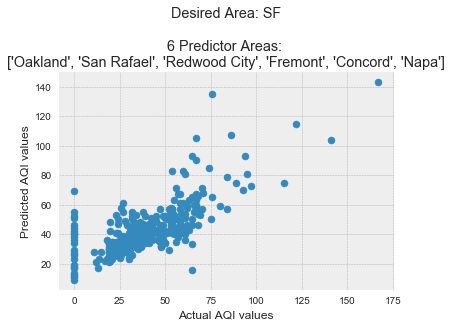

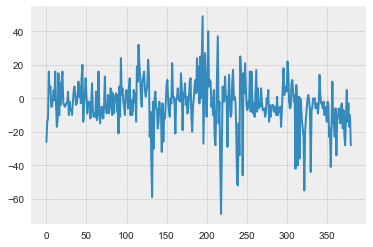

MAE: 10.36


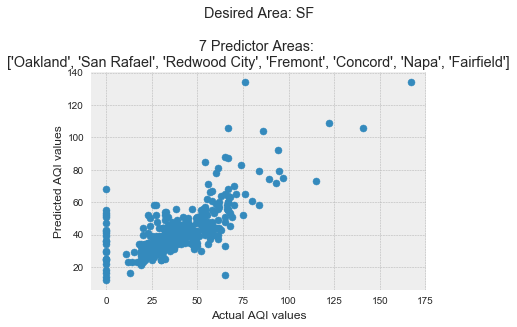

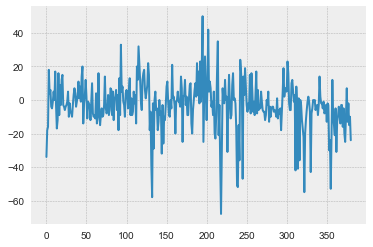

MAE: 10.41


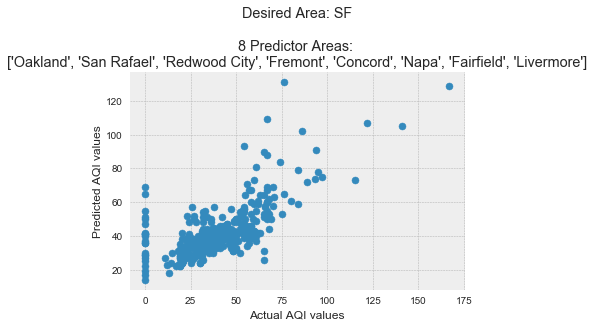

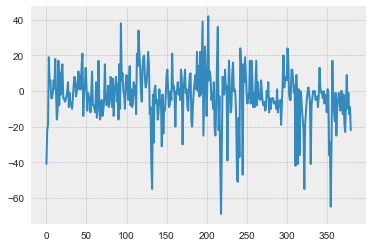

MAE: 10.3


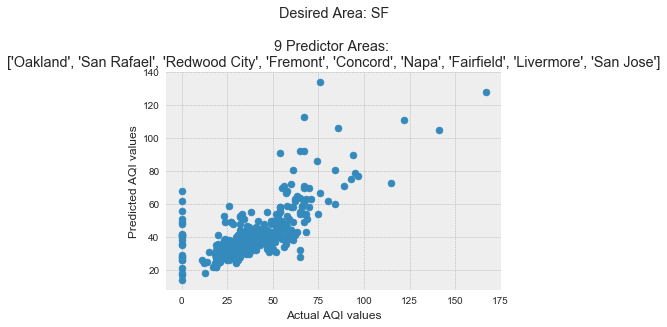

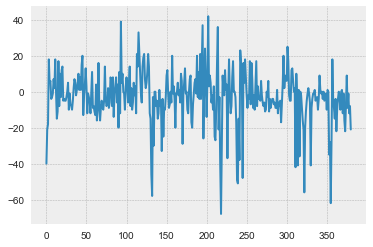

MAE: 11.37


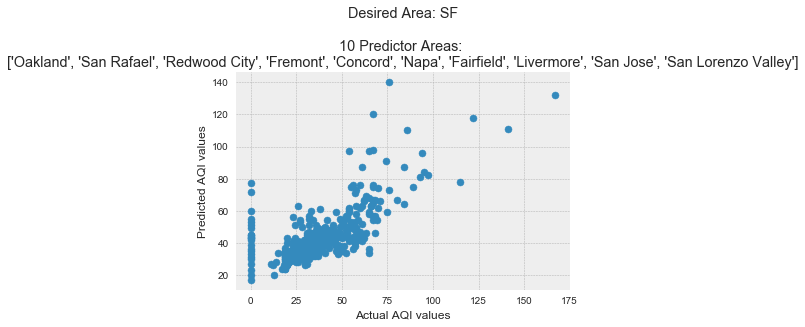

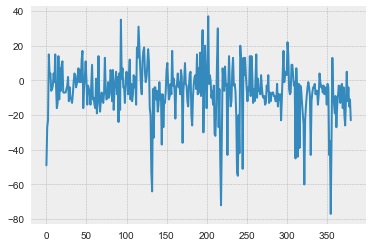

MAE: 11.53


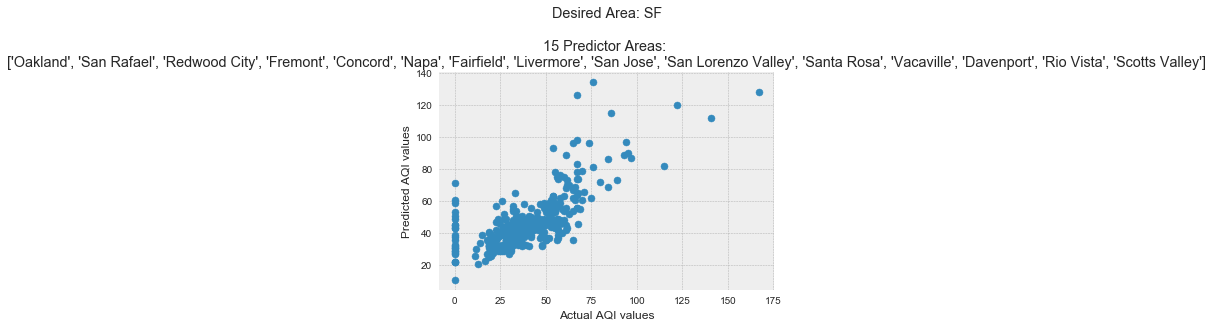

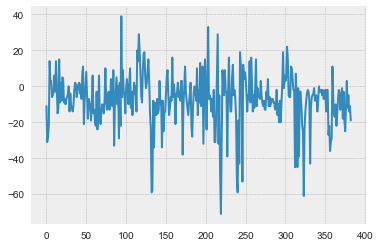

MAE: 10.58


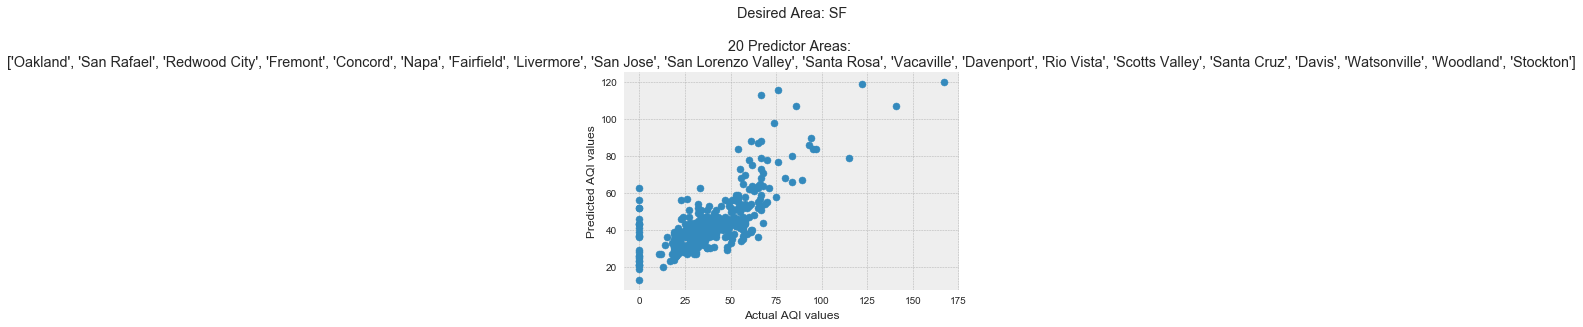

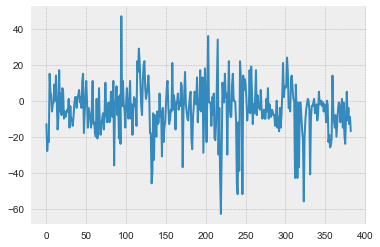

In [168]:
repareas = [1, 2, 3, 5, 6, 7, 8, 9, 10, 15, 20]
compare = gridsearch_n(repareas, data)

In [262]:
def results_compare(results):
    print('min_n', 'min_MAE')
    min_mae = min([mae[1][0] for mae in list(results.items())])
    for mae in list(results.items()):
        if mae[1][0] == min_mae:
            min_n = mae[0]
    print(min_n, '   ', min_mae)
    print('\n')
    
    print('n', 'MAE')
    for i in list(results.keys()):
        print(str(i), results[i][0])
        #print('First 15 values: ', compare[i][1])

In [263]:
results_compare(compare)

min_n min_MAE
5     9.81


n MAE
1 12.62
2 11.04
3 10.5
5 9.81
6 10.3
7 10.36
8 10.41
9 10.3
10 11.37
15 11.53
20 10.58


In [142]:
#input evaluted pred_aqis into results df
#boxplot evaluated AQI values by n reporting areas